In [16]:
!pip install ta

  Stored in directory: /root/.cache/pip/wheels/de/ac/09/28855b628633d42061f670c59df6877a1dbdf70d04c985bc18
Successfully built ta


In [0]:
import pandas as pd
import numpy as np
from pandas_datareader import data, wb
import ta as ta

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

## Data Wrangling

In [0]:
def get_data():
  """
  Downloads and wrangles data for BlackSwan 2.0 VIX modeling. 
  
  Combines the two index datasets and creating a 
  new DataFrame (df) that contains the target feature (Trading Days with 3 
  STDV shifts based on a rolling window)
  
  :input: vix  => CBOE VIX Historical Data
  :input: gspc => GSPC S&P 500 index with matching start date to VIX
  
  :return: df  => cominbation VIX/GSPC Dataset with Target Classifier 
  """
  
  ############### Getting Data ##################
  
  vix = (data.DataReader('^VIX', "yahoo", start='1992-6-22')
         .drop(columns = ['Volume', 'Adj Close']))
  
  gspc = data.DataReader('^GSPC', "yahoo", start='1992-6-22')
  
  
  ############### Wrangling Data #################
  # Rename the Columns
  vix.columns = ['vix_high', 'vix_low', 'vix_open', 'vix_close']
  gspc.columns = ['gspc_high', 'gspc_low', 'gspc_open',
                  'gspc_close','gspc_volume','gspc_adj_close']
  
  # Join the two Dataframes
  df = vix.join(gspc)
  
  # Pull Date columns out of the index
  df = df.reset_index()
  
  # Datetime Conversion
  # df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format= True)
  
  ############### Momemntum Feature Engineering ################
  
  # Awesome Oscillator
  df['mom_ao']=ta.momentum.ao(df['gspc_high'],
                              df['gspc_low'],
                              s=5,len=34,
                              fillna=True)

  # Money Flow Index
  df['mom_mf']=ta.momentum.money_flow_index(df['gspc_high'],
                                            df['gspc_low'],
                                            df['gspc_close'],
                                            df['gspc_volume'],
                                            n=14,fillna=True)
  
  # Relative Strength Index
  df['mom_rsi'] = ta.momentum.rsi(df['gspc_close'],
                                  n=14,
                                  fillna=True)
  
  # Stochasitc Oscillator
  df['mom_stoch']=ta.momentum.stoch(df['gspc_high'],
                                    df['gspc_low'],
                                    df['gspc_close'],
                                    n=14,
                                    fillna=True)
  
  # Stochasitc Signal
  df['mom_st_sig']=ta.momentum.stoch_signal(df['gspc_high'],
                                            df['gspc_low'],
                                            df['gspc_close'],
                                            n=14,
                                            d_n=3,
                                            fillna=True)
  
  # True Strength Indicator
  df['mom_tsi'] = ta.momentum.tsi(df['gspc_close'],
                                  r=25,
                                  s=13,
                                  fillna=True)
  
  # Ultimate Oscillator
  df['mom_uo'] = ta.momentum.uo(df['gspc_high'],
                                df['gspc_low'],
                                df['gspc_close'], 
                                s=7, 
                                m=14, 
                                len=28, 
                                ws=4.0, 
                                wm=2.0, 
                                wl=1.0,
                                fillna=True)
  
  # Williams %R
  df['mom_wr']=ta.momentum.wr(df['gspc_high'],
                              df['gspc_low'],
                              df['gspc_close'],
                              lbp=14,fillna=True)
  
  ############### Volume Feature Engineering ####################
  
  # Accumulation/Distribution Index
  df['vol_adi']=ta.volume.acc_dist_index(df['gspc_high'],
                                         df['gspc_low'],
                                         df['gspc_close'],
                                         df['gspc_volume'],
                                         fillna=True)
  
  # Chaikin Money Flow
  df['vol_cmf'] = ta.volume.chaikin_money_flow(df['gspc_high'],
                                               df['gspc_low'],
                                               df['gspc_close'],
                                               df['gspc_volume'],
                                               n=20,fillna=True)
  
  # Ease of Movement
  df['vol_eom'] = ta.volume.ease_of_movement(df['gspc_high'],
                                             df['gspc_low'],
                                             df['gspc_close'],
                                             df['gspc_volume'],
                                             n=20,fillna=True)
  
  # Force Index
  df['vol_fm'] = ta.volume.force_index(df['gspc_close'],
                                       df['gspc_volume'],
                                       n=2,fillna=True)
  
  # Negative Volume Index
  df['vol_nvi'] = ta.volume.negative_volume_index(df['gspc_close'],
                                                  df['gspc_volume'],
                                                  fillna=True)
  
  # On-Balance Volume
  df['vol_obv'] = ta.volume.on_balance_volume(df['gspc_close'],
                                              df['gspc_volume'],
                                              fillna=True)
  
  # Volume-Price Trend
  df['vol_vpt'] = ta.volume.volume_price_trend(df['gspc_close'],
                                               df['gspc_volume'],
                                               fillna=True)
  
  ############### Target Creation #################
  
  # Determine daily market movement between Close and Close
  df['vix_move']  = (1 - df['vix_close']
                     .shift(1)/df['vix_close'])
  
  df['gspc_move'] = (1 - df['gspc_close']
                     .shift(1)/df['gspc_close'])
  
  
  
  ##### 30 Day Rolling Average
  
  # Find the Standard Deviation based on a rolling average (year)
  df['vix_rolling_30'] = (df['vix_move']
                          .rolling(30).std())
  
  df['gspc_rolling_30'] = (df['gspc_move']
                           .rolling(30).std())
  
  # Create new target features based on Different STDEV thresholds
  df['3sd_move_30'] = np.where(abs(df['gspc_move'])
                            >=3*df['gspc_rolling_30'],1,0)
  
  df['2.5sd_move_30'] = np.where(abs(df['gspc_move'])
                            >=2.5*df['gspc_rolling_30'],1,0)
  
  df['2sd_move_30'] = np.where(abs(df['gspc_move'])
                            >=2*df['gspc_rolling_30'],1,0)
  
  df['1.5sd_move_30'] = np.where(abs(df['gspc_move'])
                            >=1.5*df['gspc_rolling_30'],1,0)
  
  
  ##### 90 Day Rolling Average
  
  # Find the Standard Deviation based on a rolling average (year)
  df['vix_rolling_90'] = (df['vix_move']
                          .rolling(90).std())
  
  df['gspc_rolling_90'] = (df['gspc_move']
                           .rolling(90).std())
  
  # Create new target features based on Different STDEV thresholds
  df['3sd_move_90'] = np.where(abs(df['gspc_move'])
                            >=3*df['gspc_rolling_90'],1,0)
  
  df['2.5sd_move_90'] = np.where(abs(df['gspc_move'])
                            >=2.5*df['gspc_rolling_90'],1,0)
  
  df['2sd_move_90'] = np.where(abs(df['gspc_move'])
                            >=2*df['gspc_rolling_90'],1,0)
  
  df['1.5sd_move_90'] = np.where(abs(df['gspc_move'])
                            >=1.5*df['gspc_rolling_90'],1,0)
  
  
  ##### 120 Day Rolling Average
  
  # Find the Standard Deviation based on a rolling average (year)
  df['vix_rolling_120'] = (df['vix_move']
                          .rolling(120).std())
  
  df['gspc_rolling_120'] = (df['gspc_move']
                           .rolling(120).std())
  
  # Create new target features based on Different STDEV thresholds
  df['3sd_move_120'] = np.where(abs(df['gspc_move'])
                            >=3*df['gspc_rolling_120'],1,0)
  
  df['2.5sd_move_120'] = np.where(abs(df['gspc_move'])
                            >=2.5*df['gspc_rolling_120'],1,0)
  
  df['2sd_move_120'] = np.where(abs(df['gspc_move'])
                            >=2*df['gspc_rolling_120'],1,0)
  
  df['1.5sd_move_120'] = np.where(abs(df['gspc_move'])
                            >=1.5*df['gspc_rolling_120'],1,0)
  
  
  ##### 252 Day Rolling Average
  
  # Find the Standard Deviation based on a rolling average (year)
  df['vix_rolling_252'] = (df['vix_move']
                          .rolling(252).std())
  
  df['gspc_rolling_252'] = (df['gspc_move']
                           .rolling(252).std())
  
  # Create new target features based on Different STDEV thresholds
  df['3sd_move_252'] = np.where(abs(df['gspc_move'])
                            >=3*df['gspc_rolling_252'],1,0)
  
  df['2.5sd_move_252'] = np.where(abs(df['gspc_move'])
                            >=2.5*df['gspc_rolling_252'],1,0)
  
  df['2sd_move_252'] = np.where(abs(df['gspc_move'])
                            >=2*df['gspc_rolling_252'],1,0)
  
  df['1.5sd_move_252'] = np.where(abs(df['gspc_move'])
                            >=1.5*df['gspc_rolling_252'],1,0)
  
  
  ############## Dropping Null Values ##################
  
  df = df.dropna()
  
  return df
  

In [0]:
df = get_data()

In [0]:
def crash_dates():

  start_date = '2008-09-10'
  end_date = '2009-03-05'
  crash = (df[df['Date'] > start_date])
  crash = (crash[crash['Date'] < end_date])
  
  return crash

In [0]:
#Dates of 3 STDEV movements
sd_3_dates = df[df['3sd_move'] == 1]['Date']

In [0]:
print(df.shape,'\n', df.isnull().sum(),'\n',
      df.info(),'\n', df.describe(),'\n\n')
df.head()

## Target and Features

In [0]:
targets  = ['1.5sd_move_30','2sd_move_30','2.5sd_move_30','3sd_move_30',
            '1.5sd_move_90','2sd_move_90','2.5sd_move_90','3sd_move_90',
            '1.5sd_move_120','2sd_move_120','2.5sd_move_120','3sd_move_120',
            '1.5sd_move_252','2sd_move_252','2.5sd_move_252','3sd_move_252']

leakage  = ['Date']

features  = (df.drop(columns = targets)
            .drop(columns = leakage)
            .columns)

## Baseline Modeling

In [0]:
# Baseline Modeling Imports

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix

In [0]:
def split(target, features=features):
    """
    Temporal Train Test Split. Holdout is most recent data.  
    """
    
    X = df[features]
    y = df[target]
    
    X_train = X[:int(len(X.index)*.7)]
    X_test= X[int(len(X.index)*.7):len(X.index)]
    y_train=y[:int(len(y.index)*.7)]
    y_test=y[int(len(y.index)*.7):len(y.index)]
    
    return X_train, X_test, y_train, y_test
    

In [0]:
def log_reg(target):
  
  X_train, X_test, y_train, y_test = split(target)
  
  
  LR=LogisticRegression(solver='lbfgs')
  LR.fit(X_train,y_train)
               
  #Predict the y test 
  
  y_pred_LR=LR.predict(X_test)   
               
               #Print the accuracy score of our predicted y using metrics from sklearn
  
  score = metrics.accuracy_score(y_test, y_pred_LR)
  
  return score

In [0]:
def gauss(target):
  
    X_train, X_test, y_train, y_test = split(target)

    GNB = GaussianNB()
    GNB.fit(X_train,y_train)
               #Predict the y test
    y_pred=GNB.predict(X_test)
               #Print the accuracy score of our predicted y using metrics from sklearn
    
    return 

In [0]:
def check_models():
  
  print('Baseline Probability')
  for target in targets:
    print(target+':', df[target].value_counts(normalize=True)[0],'\n')
  print('\n\n Logisitic Regression:\n')
  for target in targets:
    print(target+":", log_reg(target),'\n')
  print('\n\n Gaussian Naive Bayes:\n')
  for target in targets: 
    print(target+":", gauss(target),'\n')

In [0]:
def results(y_test, y_pred):

  print(' Accuracy: ', accuracy_score(y_test, y_pred),'\n',
        'Precision: ', precision_score(y_test, y_pred), '\n',
        '   Recall: ', recall_score(y_test, y_pred), '\n',
        '  ROC_AUC: ', roc_auc_score(y_test, y_pred), '\n\n')
        
  return pd.DataFrame(confusion_matrix(y_test, y_pred),
                      columns = ['predicted_0', 'predicted_1'],
                      index = ['actaul_0', 'actual_1'])

In [0]:
  
X_train, X_test, y_train, y_test = split('1.5sd_move_30')

GNB = GaussianNB()
GNB.fit(X_train,y_train)
               #Predict the y test
y_pred=GNB.predict(X_test)

In [23]:
results(y_test, y_pred)

 Accuracy:  0.8473282442748091 
 Precision:  0.39880952380952384 
    Recall:  0.2518796992481203 
   ROC_AUC:  0.5962164829377741 




,predicted_0,predicted_1
actaul_0,1598,101
actual_1,199,67


In [78]:
gauss('1.5sd_move_30')

AttributeError: ignored

## ARIMA Modeling

In [0]:
#ARIMA Modeling Imports

from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt

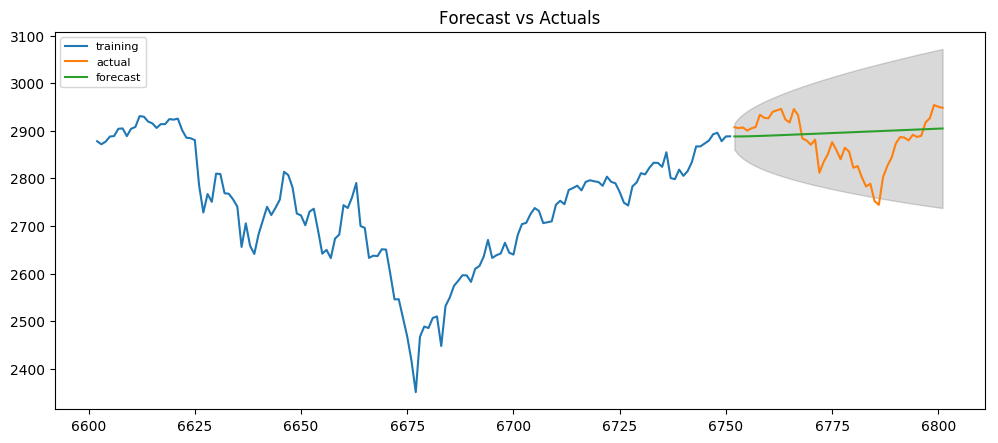

In [0]:

train = df.gspc_close[1:-50]
test = df.gspc_close[-50:]
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  
fc, se, conf = fitted.forecast(50, alpha=0.05) 
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train[-150:], label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6550 entries, 252 to 6801
Data columns (total 40 columns):
Date                6550 non-null datetime64[ns]
vix_high            6550 non-null float64
vix_low             6550 non-null float64
vix_open            6550 non-null float64
vix_close           6550 non-null float64
gspc_high           6550 non-null float64
gspc_low            6550 non-null float64
gspc_open           6550 non-null float64
gspc_close          6550 non-null float64
gspc_volume         6550 non-null int64
gspc_adj_close      6550 non-null float64
mom_ao              6550 non-null float64
mom_mf              6550 non-null float64
mom_rsi             6550 non-null float64
mom_stoch           6550 non-null float64
mom_st_sig          6550 non-null float64
mom_tsi             6550 non-null float64
mom_uo              6550 non-null float64
mom_wr              6550 non-null float64
vol_adi             6550 non-null float64
vol_cmf             6550 non-null float64
vol_

In [39]:
df.head()

,Date,vix_high,vix_low,vix_open,vix_close,gspc_high,gspc_low,gspc_open,gspc_close,gspc_volume,gspc_adj_close,mom_ao,mom_mf,mom_rsi,mom_stoch,mom_st_sig,mom_tsi,mom_uo,mom_wr,vol_adi,vol_cmf,vol_eom,vol_fm,vol_nvi,vol_obv,vol_vpt,vix_move,gspc_move,vix_rolling_30,gspc_rolling_30,3sd_move_30,2.5sd_move_30,2sd_move_30,1.5sd_move_30,vix_rolling_90,gspc_rolling_90,3sd_move_90,2.5sd_move_90,2sd_move_90,1.5sd_move_90,vix_rolling_120,gspc_rolling_120,3sd_move_120,2.5sd_move_120,2sd_move_120,1.5sd_move_120,vix_rolling_252,gspc_rolling_252,3sd_move_252,2.5sd_move_252,2sd_move_252,1.5sd_move_252
252,1993-06-21,12.65,12.23,12.57,12.25,446.220001,443.679993,443.679993,446.220001,223650000,446.220001,-0.011211,49.803673,46.918655,23.901215,21.832913,3.014690,51.119682,-76.098785,-7.685000e+07,0.071172,-3.488361e-09,3.749132e+07,1010.316219,4.118300e+09,-1.975608e+06,0.000816,0.005692,0.040605,0.006251,0,0,0,0,0.054836,0.006794,0,0,0,0,0.050681,0.006324,0,0,0,0,0.047425,0.005959,0,0,0,0
253,1993-06-22,12.07,11.39,11.67,11.65,446.290009,444.940002,446.250000,445.929993,259530000,445.929993,-0.387003,41.738429,45.919186,22.656276,15.713304,2.776367,50.729522,-77.343724,3.447585e+08,0.065872,-2.600670e-09,-9.218250e+07,1010.316219,3.858770e+09,1.111692e+06,-0.051502,-0.000650,0.040195,0.006251,0,0,0,0,0.054763,0.006785,0,0,0,0,0.050830,0.006322,0,0,0,0,0.046645,0.005959,0,0,0,0
254,1993-06-23,12.33,11.14,11.24,12.04,445.959991,443.190002,445.959991,443.190002,278260000,443.190002,-0.565707,41.890905,37.265248,0.000000,15.519163,2.181439,46.470929,-100.000000,-1.571515e+08,-0.021471,-3.576870e-09,-1.654682e+08,1010.316219,3.580510e+09,-1.878426e+06,0.032392,-0.006182,0.040584,0.006325,0,0,0,0,0.054832,0.006777,0,0,0,0,0.050926,0.006314,0,0,0,0,0.046693,0.005973,0,0,0,0
255,1993-06-24,12.97,12.24,12.91,12.25,447.209991,442.500000,443.040009,446.619995,267450000,446.619995,-1.213121,49.066007,50.688552,49.939335,24.198537,2.103735,55.663196,-50.060665,-7.781416e+07,-0.034507,-5.720385e-09,5.464819e+06,1018.135388,3.847960e+09,3.601312e+05,0.017143,0.007680,0.040613,0.006481,0,0,0,0,0.049799,0.006302,0,0,0,0,0.050648,0.006351,0,0,0,0,0.046708,0.005989,0,0,0,0
256,1993-06-25,12.15,11.11,12.15,11.25,448.640015,446.619995,446.619995,447.600006,210430000,447.600006,-1.059266,55.532718,53.937791,78.703664,42.881000,2.164260,51.430486,-21.296336,1.941958e+08,-0.020903,-5.340670e-09,-2.991305e+08,1020.369465,4.058390e+09,2.531626e+06,-0.088889,0.002189,0.040143,0.006020,0,0,0,0,0.050575,0.006302,0,0,0,0,0.051265,0.006349,0,0,0,0,0.047011,0.005990,0,0,0,0


In [0]:
VVIX = data.DataReader('^VVIX', 'yahoo', '1992-6-22')

In [0]:
VVIX